In [1]:
# suppress "Future warning"
import warnings as w
w.filterwarnings('ignore')

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read dataset
df = pd.read_csv('RawMaterialHistory.csv')

In [2]:
# drop rows with Amount = 0 
df.drop(df[df['Amount'] == 0].index, inplace = True)
# rename column from ‘Lot #’ to 'Lot'
df.rename(columns={"(+ / -)": "Changes",'Lot #': 'Lot' }, inplace = True)
# set the format of Date column to show just data in format of date dd/mm/yyyy
df['Date'] = pd.to_datetime(df["Date"]).dt.normalize()
# convert Amount into KG and L
df['Amount'] = np.where(df['Units'].isin(['g','ml']), df['Amount'].astype(int) / 1000, df['Amount'])
# define a new column to hold the absolute value of Amounts for further calculations
df['Amounts'] = df["Amount"].abs()
# rename units from g to KG and ml to L
df['Units'] = df['Units'].mask(df.Units == "g", "KG").mask(df.Units == "ml", "L").mask(df.Units == "each", "Each").mask(df.Units == "kg", "KG")
# define a new column to hold the the volume of each batch based the name of Brand
df['Volume (L)'] = df['Brand'].str.extract(r'\(([^()]+)\)')
# extract a subset of columns inclcuding 'Name', 'Changes','Amount', 'Units','Date','Amounts' columns 
# for calculating and visualizing the stock level of the raw material and CO2 footprint
df_clean = df[['Name', 'Changes','Amount', 'Units','Date','Amounts' ]].sort_values(by=['Name'])
# extract a subset of data which contains jus used materials
df_sub = df_clean[df_clean['Changes'] == 'Subtract']
# extract a subset of data which contains just added materials
df_add = df_clean[df_clean['Changes'] == 'Add']
# extract a subset of data which contains just the added materials with duplicate rows removed
# The objective is to record the initial date that a material is added to the process so that it can be used as a reference point for determining the current inventory level of the raw materials.
df_add_nodup = df_add.drop_duplicates(subset=["Name"], keep='first')

In [3]:
# extract a subset of data which contains materials which are added and used after the reference point 
# the reference point for each material is different
df_clean_add_sub = pd.DataFrame(data=None, columns=df_clean.columns)
for idx, row in df_clean.iterrows():
    for idx2, row2 in df_add_nodup.iterrows():
        if row['Name'] == row2['Name'] and row['Date'] >= row2['Date']:
            df_clean_add_sub = df_clean_add_sub.append(row).drop_duplicates()
# sort the values based on Name and Date
df_clean_add_sub.sort_values(['Name','Date'],ascending=True).groupby(['Name'])


<AxesSubplot:xlabel='Name,Changes,Units'>

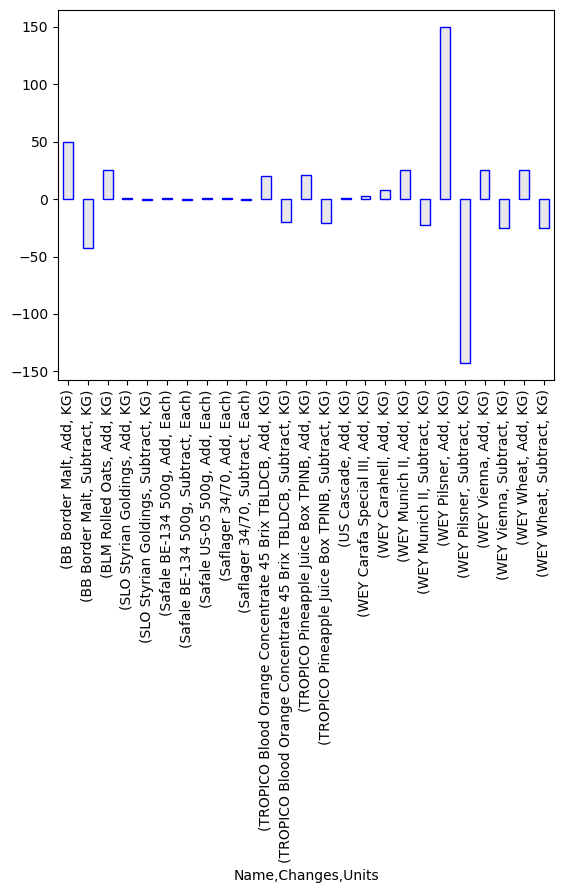

In [4]:
# visualise the stock level (added and subtracted)
stock_level_add_sub = df_clean_add_sub.groupby(['Name', 'Changes','Units'])['Amount'].sum()
stock_level_add_sub.plot.bar(color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

In [5]:
# show a subset of data which contains added materials
stock_level_add_sub

Name                                             Changes   Units
BB Border Malt                                   Add       KG        50.0
                                                 Subtract  KG       -43.0
BLM Rolled Oats                                  Add       KG        25.0
SLO Styrian Goldings                             Add       KG         1.0
                                                 Subtract  KG        -0.8
Safale BE-134 500g                               Add       Each       1.0
                                                 Subtract  Each      -1.0
Safale US-05 500g                                Add       Each       1.0
Saflager 34/70                                   Add       Each       1.0
                                                 Subtract  Each      -1.0
TROPICO Blood Orange Concentrate 45 Brix TBLDCB  Add       KG        20.0
                                                 Subtract  KG       -20.0
TROPICO Pineapple Juice Box TPINB              

<AxesSubplot:xlabel='Name,Units'>

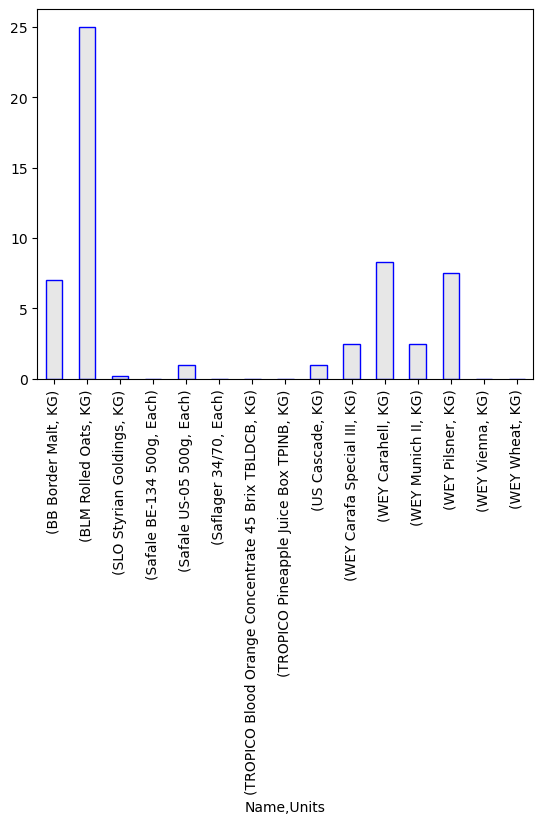

In [6]:
# show a subset of data which contains added materials
stock_level = df_clean_add_sub.groupby(['Name', 'Units'])['Amount'].sum()
stock_level.plot.bar(color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

In [ ]:
# visualise the stock level
stock_level

In [ ]:
# export the results into csv files to be used in power BI for visualisation
stock_level.to_csv('stock_level.csv')
stock_level_add_sub.to_csv('stock_level_add_sub.csv')
df_clean.to_csv('df_clean.csv')
df.to_csv('df.csv')